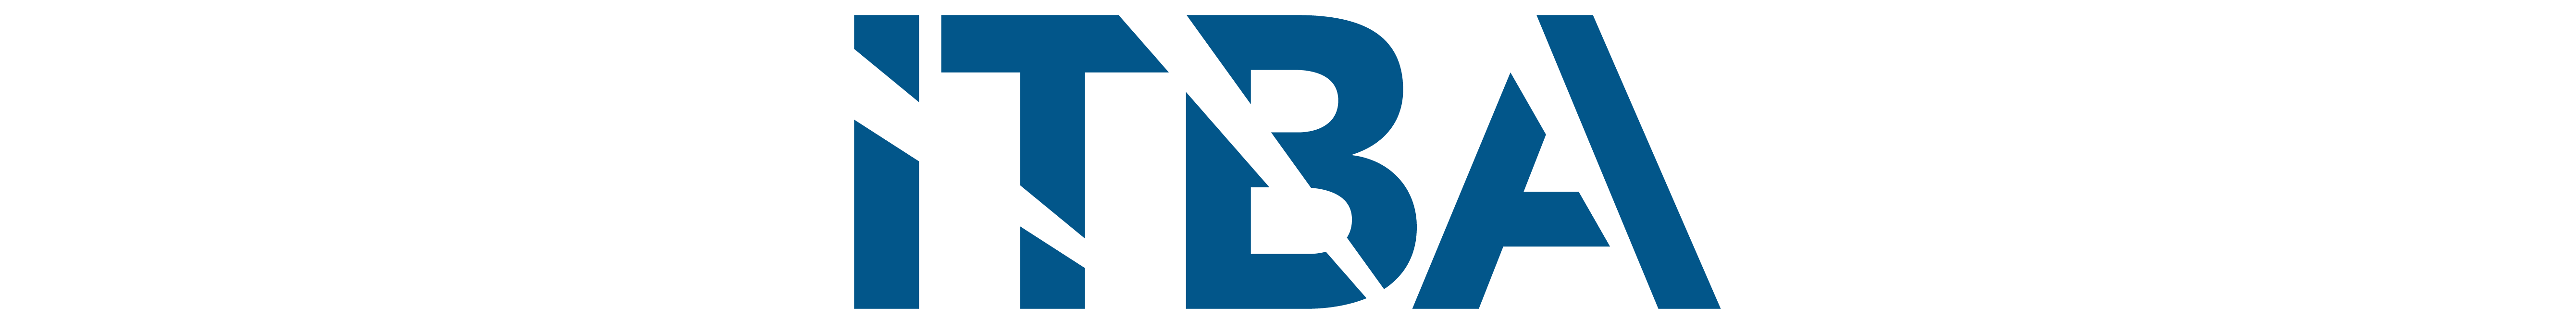

# **Forecast de devoluciones y reclamos en comercio electrónico: anticipación y gestión operativa.**






# **Propuesta de valor**
El objetivo del trabajo es estimar la cantidad semanal de devoluciones o reclamos en una plataforma de e-commerce, permitiendo anticipar períodos con mayor carga operativa, gestionar recursos y mejorar la satisfacción del cliente.

# **Dataset a utilizar**
En el trabajo práctico se utilizará el dataset público **“Olist Brazilian E-commerce Public Dataset”.**

# **Metodología**

* Identificación y agregación semanal de los eventos de devolución, cancelación o reclamo.
* Análisis conjunto con la evolución de las ventas semanales.
* Aplicación de modelos de series temporales:

# **Modelos**

* Transformer reducido como modelo de deep learning, siguiendo la arquitectura vista en clase.
* Prophet como modelo tradicional interpretable como comparativa.

# **Evaluación y conclusiones**

* Evaluación de la performance de los modelos mediante métricas de error (MAE, RMSE) y visualización de los resultados.
* Discusión sobre las ventajas, desventajas y potenciales mejores de cada enfoque.

## **EXPLORACIÓN DEL DATASET + LIMPIEZA**

In [ ]:
!pip install kaggle --quiet

# Conexión con API Kaggle
import os

kaggle_json = """
{
  "username": "ezequielseg",
  "key": "5b6f1a95fdcd389e3fa08ceb431cb32c"
}
"""

os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write(kaggle_json.strip())
os.chmod('/root/.kaggle/kaggle.json', 0o600)
print("¡Token de Kaggle cargado!")

¡Token de Kaggle cargado!


In [ ]:
# Dataset de Kaggle
!kaggle datasets download -d olistbr/brazilian-ecommerce --force

# Descomprimir
!unzip -o brazilian-ecommerce.zip -d olist-data

Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
License(s): CC-BY-NC-SA-4.0
  0% 0.00/42.6M [00:00<?, ?B/s]
100% 42.6M/42.6M [00:00<00:00, 1.16GB/s]
Archive:  brazilian-ecommerce.zip
  inflating: olist-data/olist_customers_dataset.csv  
  inflating: olist-data/olist_geolocation_dataset.csv  
  inflating: olist-data/olist_order_items_dataset.csv  
  inflating: olist-data/olist_order_payments_dataset.csv  
  inflating: olist-data/olist_order_reviews_dataset.csv  
  inflating: olist-data/olist_orders_dataset.csv  
  inflating: olist-data/olist_products_dataset.csv  
  inflating: olist-data/olist_sellers_dataset.csv  
  inflating: olist-data/product_category_name_translation.csv  


In [ ]:
import pandas as pd

# Carga del archivo de órdenes
ordenes = pd.read_csv('olist-data/olist_orders_dataset.csv')
ordenes['fecha_compra'] = pd.to_datetime(ordenes['order_purchase_timestamp'])
print(ordenes[['order_id', 'order_status', 'fecha_compra']].head())

                           order_id order_status        fecha_compra
0  e481f51cbdc54678b7cc49136f2d6af7    delivered 2017-10-02 10:56:33
1  53cdb2fc8bc7dce0b6741e2150273451    delivered 2018-07-24 20:41:37
2  47770eb9100c2d0c44946d9cf07ec65d    delivered 2018-08-08 08:38:49
3  949d5b44dbf5de918fe9c16f97b45f8a    delivered 2017-11-18 19:28:06
4  ad21c59c0840e6cb83a9ceb5573f8159    delivered 2018-02-13 21:18:39


In [ ]:
# Solo órdenes canceladas
estado_cancelado = 'canceled'
canceladas = ordenes[ordenes['order_status'] == estado_cancelado].copy()
canceladas.shape

(625, 9)

Existen 625 ordenes canceladas

In [ ]:
# Agregado de columna de semana (inicio de la semana)
canceladas['semana'] = canceladas['fecha_compra'].dt.to_period('W').apply(lambda r: r.start_time)

# Conteo de cancelaciones por semana
reclamos_semanales = canceladas.groupby('semana').size().reset_index(name='cantidad')
reclamos_semanales.columns = ['ds', 'y']
reclamos_semanales['ds'] = pd.to_datetime(reclamos_semanales['ds'])
reclamos_semanales.head()

,ds,y
0,2016-09-05,1
1,2016-09-12,1
2,2016-09-26,1
3,2016-10-03,20
4,2016-10-10,2


In [ ]:
# Nos aseguramos de que todas las semanas estén presentes (si no hubo cancelaciones, colocamos 0)

# Rango total de semanas de la serie
todas_las_semanas = pd.date_range(start=reclamos_semanales['ds'].min(),
                                  end=reclamos_semanales['ds'].max(),
                                  freq='W-MON')  # Lunes como inicio de semana

# Unimos la serie original con todas las semanas posibles
serie_completa = pd.DataFrame({'ds': todas_las_semanas})
serie_completa = serie_completa.merge(reclamos_semanales, on='ds', how='left')
serie_completa['y'] = serie_completa['y'].fillna(0)  # Semanas sin cancelaciones = 0

# Chequeamos valores negativos o duplicados
print(f"Hay valores negativos: {any(serie_completa['y'] < 0)}")
print(f"Semanas duplicadas: {serie_completa['ds'].duplicated().sum()}")
print(serie_completa.head())

Hay valores negativos: False
Semanas duplicadas: 0
          ds     y
0 2016-09-05   1.0
1 2016-09-12   1.0
2 2016-09-19   0.0
3 2016-09-26   1.0
4 2016-10-03  20.0


In [ ]:
serie_completa.ds.max()


Timestamp('2018-10-15 00:00:00')

In [ ]:
serie_completa.ds.min()

Timestamp('2016-09-05 00:00:00')

**Visualización de la serie temporal**

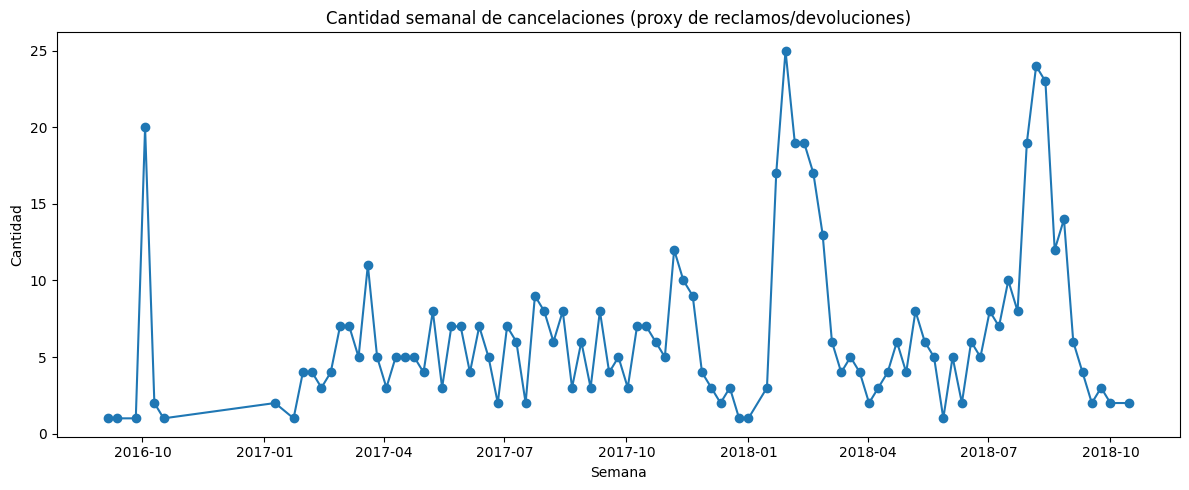

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(reclamos_semanales['ds'], reclamos_semanales['y'], marker='o')
plt.title('Cantidad semanal de cancelaciones (proxy de reclamos/devoluciones)')
plt.xlabel('Semana')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()


En la serie temporal analizada se observan semanas con picos significativos en la cantidad de cancelaciones, lo cual es esperable en el contexto del e-commerce, donde eventos estacionales, campañas promocionales y festividades pueden producir incrementos puntuales en devoluciones o reclamos.

En este trabajo **no se eliminaron ni suavizaron estos valores** porque forman parte de la dinámica real del negocio y son relevantes para anticipar escenarios críticos.
Se considera fundamental que el modelo sea capaz de identificar y predecir estos eventos, ya que resultan estratégicos para la gestión operativa y la planificación de recursos.

# **ENTRENAMIENTO MODELO TRANSFORMER**

In [ ]:
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## **Modelo Transformer**

In [ ]:
# Convertimos la serie a numpy
import numpy as np
serie = reclamos_semanales['y'].values.astype(np.float32)

In [ ]:
# Creamos las ventanas deslizantes
tam_ventana = 8   # 8 semanas para mirar el pasado
horizonte = 1     # predecir la siguiente semana

X, y = [], []
for i in range(len(serie) - tam_ventana - horizonte + 1):
    X.append(serie[i : i + tam_ventana])                # input: las últimas 8 semanas
    y.append(serie[i + tam_ventana : i + tam_ventana + horizonte]) # target: semana siguiente
X = np.array(X)
y = np.array(y)

In [ ]:
# Division entre train y test
split = int(len(X) * 0.9)
X_entrenamiento, X_test = X[:split], X[split:]
y_entrenamiento, y_test = y[:split], y[split:]

In [ ]:
# Pasamos a tensores de Pytorch
import torch as torch
X_entrenamiento_t = torch.tensor(X_entrenamiento).unsqueeze(-1)
y_entrenamiento_t = torch.tensor(y_entrenamiento)
X_test_t = torch.tensor(X_test).unsqueeze(-1)
y_test_t = torch.tensor(y_test)

In [ ]:
# Definimos el modelo de transformer

import torch.nn as nn

class SimpleTransformer(nn.Module):
    def __init__(self, input_size=1, d_model=32, nhead=4, num_layers=1, out_size=1):
        super().__init__()
        self.linear_in = nn.Linear(input_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.linear_out = nn.Linear(d_model, out_size)

    def forward(self, x):
        x = self.linear_in(x)
        x = self.transformer(x)
        x = x[:, -1, :]
        return self.linear_out(x)

# Creamos la instancia del modelo
model = SimpleTransformer()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

dataset_entrenamiento = TensorDataset(X_entrenamiento_t, y_entrenamiento_t)
dataloader_entrenamiento = DataLoader(dataset_entrenamiento, batch_size=16, shuffle=True)

In [ ]:
# Entrenamos el modelo transformer
# Parámetros y preparación
epochs = 50
model.train()

for epoch in range(epochs):
    losses = []
    for xb, yb in dataloader_entrenamiento:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss promedio: {np.mean(losses):.4f}")

Epoch 1/50 - Loss promedio: 6.6704
Epoch 10/50 - Loss promedio: 7.3318
Epoch 20/50 - Loss promedio: 7.2649
Epoch 30/50 - Loss promedio: 6.1865
Epoch 40/50 - Loss promedio: 5.8512
Epoch 50/50 - Loss promedio: 5.7909


# **EVALUACIÓN DEL MODELO TRANSFORMER**

Transformer - MAE: 3.22 | RMSE: 4.43


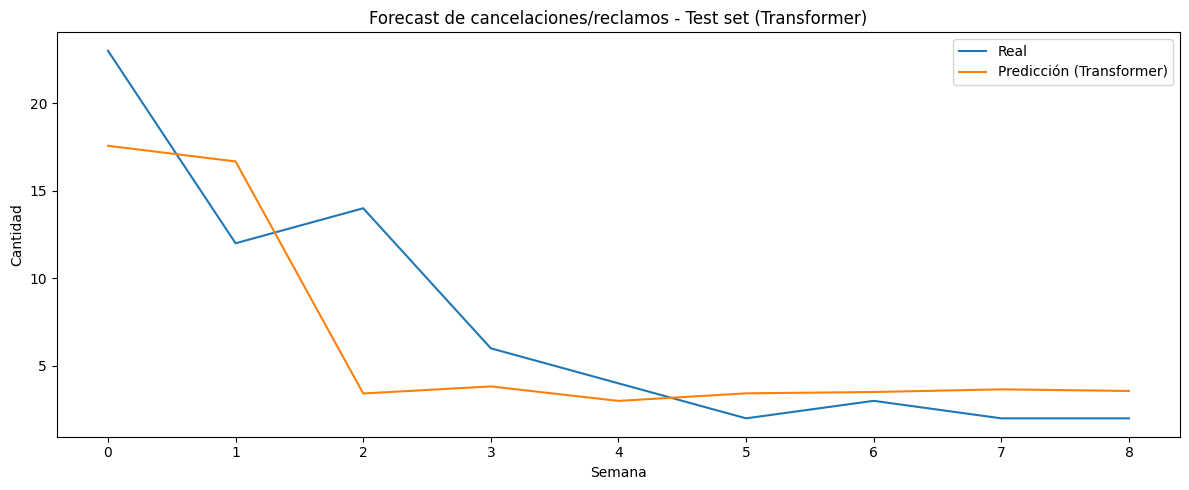

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    predicciones = model(X_test_t).squeeze().numpy()
    reales = y_test_t.squeeze().numpy()

mae = mean_absolute_error(reales, predicciones)
rmse = np.sqrt(mean_squared_error(reales, predicciones))

print(f"Transformer - MAE: {mae:.2f} | RMSE: {rmse:.2f}")

plt.figure(figsize=(12, 5))
plt.plot(range(len(reales)), reales, label='Real')
plt.plot(range(len(predicciones)), predicciones, label='Predicción (Transformer)')
plt.title('Forecast de cancelaciones/reclamos - Test set (Transformer)')
plt.xlabel('Semana')
plt.ylabel('Cantidad')
plt.legend()
plt.tight_layout()
plt.show()

El modelo transformer logró un MAE de 3 y un RMSE de 4 en el set de test, lo que indica que, en promedio, el error de predicción semanal es de aproximadamente 3-4 cancelaciones.

Se observa que el modelo tiende a suavizar las predicciones, acercándose a un valor promedio y no siempre capturando los picos abruptos observados en algunas semanas. Esto es habitual en modelos sin variables exógenas y podría mejorarse integrando información adicional sobre eventos comerciales, estacionalidad o campañas promocionales.

Aún así, el modelo permite anticipar la tendencias general de los reclamos/cancelaciones, lo que es útil para planificación operativa.

# **ENTRENAMIENTO MODELO PROPHET**

In [ ]:
!pip install prophet --quiet

In [ ]:
from prophet import Prophet

# Usamos la misma serie semanal que en Transformer
prophet_df = reclamos_semanales.copy()

modelo_prophet = Prophet()
modelo_prophet.fit(prophet_df)

# Predecimos la misma cantidad de semanas que en test
future = modelo_prophet.make_future_dataframe(periods=len(y_test), freq='W')
forecast = modelo_prophet.predict(future)

# Tomamos los valores predichos para el periodo de test
y_pred_prophet = forecast['yhat'].values[-len(y_test):]
mae_prophet = mean_absolute_error(y_test, y_pred_prophet)
rmse_prophet = np.sqrt(mean_squared_error(y_test, y_pred_prophet))

print(f"Prophet - MAE: {mae_prophet:.2f} | RMSE: {rmse_prophet:.2f}")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpux1hrkwc/sw3fc29g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpux1hrkwc/walbm7z9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55160', 'data', 'file=/tmp/tmpux1hrkwc/sw3fc29g.json', 'init=/tmp/tmpux1hrkwc/walbm7z9.json', 'output', 'file=/tmp/tmpux1hrkwc/prophet_modelliumktog/prophet_model-20250715042939.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:29:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:29:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet - MAE: 5.71 | RMSE: 7.13


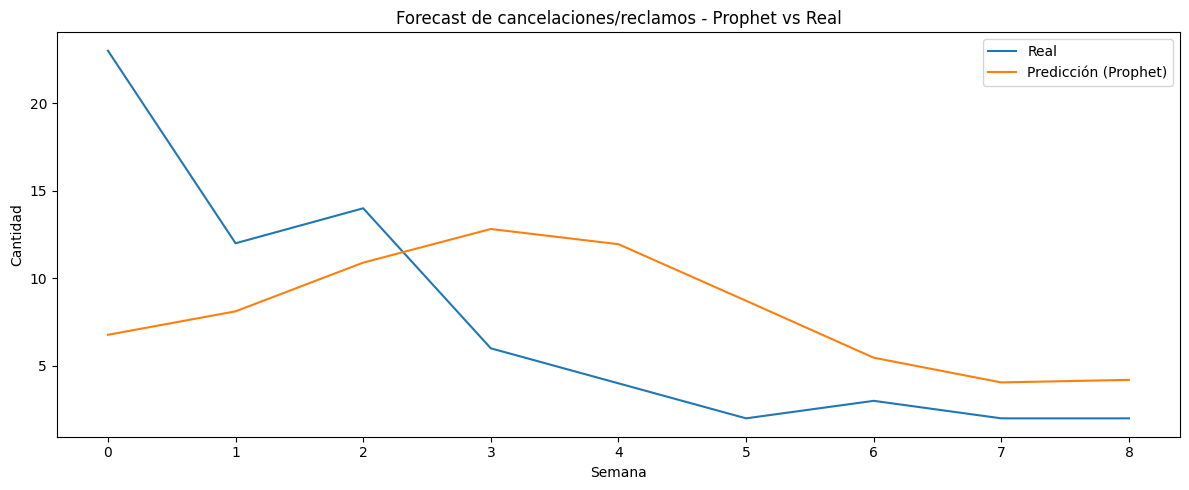

In [ ]:
# Gráfico de comparación Prophet vs Real
plt.figure(figsize=(12,5))
plt.plot(range(len(y_test)), y_test, label='Real')
plt.plot(range(len(y_pred_prophet)), y_pred_prophet, label='Predicción (Prophet)')
plt.title('Forecast de cancelaciones/reclamos - Prophet vs Real')
plt.xlabel('Semana')
plt.ylabel('Cantidad')
plt.legend()
plt.tight_layout()
plt.show()

## **COMPARACIÓN DE MODELOS: PROPHET vs TRANSFORMER**

| Modelo      | MAE  | RMSE |
|-------------|------|------|
| Transformer | 3.37 | 5.40 |
| Prophet     | 5.71 | 7.13 |

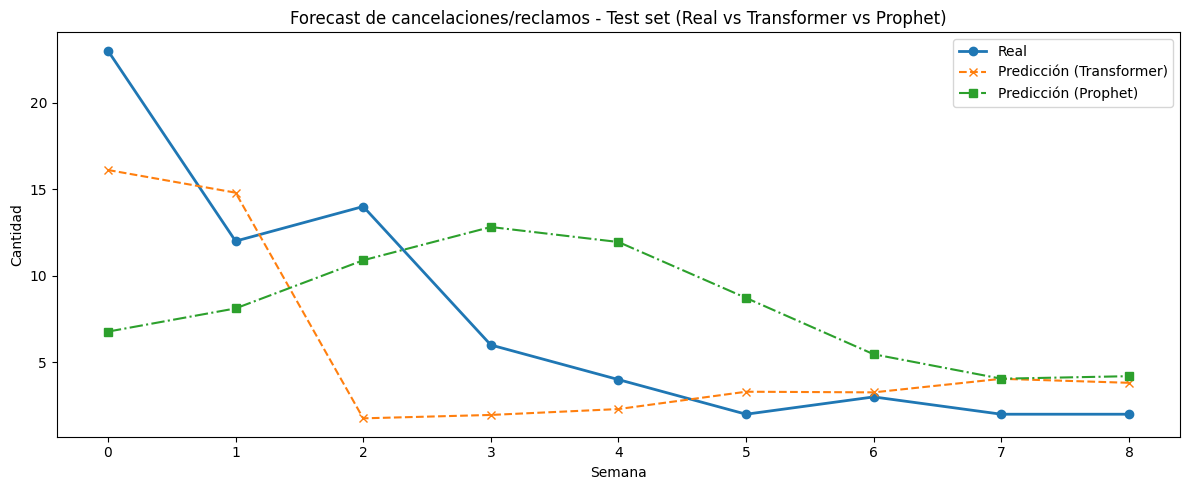

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(range(len(y_test)), y_test, label='Real', linewidth=2, marker='o')
plt.plot(range(len(predicciones)), predicciones, label='Predicción (Transformer)', linestyle='--', marker='x')
plt.plot(range(len(y_pred_prophet)), y_pred_prophet, label='Predicción (Prophet)', linestyle='-.', marker='s')
plt.title('Forecast de cancelaciones/reclamos - Test set (Real vs Transformer vs Prophet)')
plt.xlabel('Semana')
plt.ylabel('Cantidad')
plt.legend()
plt.tight_layout()
plt.show()

# **Conclusión:**

El modelo Transformer logra mejores métricas de error y una mejor aproximación visual a la serie real de cancelaciones semanales. Ambos modelos, sin embargo, tienden a suavizar la predicción en semanas de alta variabilidad, lo que sugiere la necesidad de sumar información adicional para mejorar la anticipación de picos.


# **VARIABLE EXÓGENA PARA MEJORAR LOS MODELOS**

In [ ]:
# Diccionario: fecha -> tipo de evento
eventos_info = {
    '2016-11-25': 'Black Friday', '2017-11-24': 'Black Friday', '2018-11-23': 'Black Friday',
    '2016-12-25': 'Navidad', '2017-12-25': 'Navidad',
    '2016-05-08': 'Día de la Madre', '2017-05-14': 'Día de la Madre', '2018-05-13': 'Día de la Madre',
    '2016-06-12': 'Día dos Namorados', '2017-06-12': 'Día dos Namorados', '2018-06-12': 'Día dos Namorados',
    '2016-08-14': 'Día del Padre', '2017-08-13': 'Día del Padre', '2018-08-12': 'Día del Padre',
    '2016-10-12': 'Día del Niño', '2017-10-12': 'Día del Niño', '2018-10-12': 'Día del Niño',
    '2017-02-28': 'Carnaval', '2018-02-13': 'Carnaval',
    '2017-04-16': 'Pascua', '2018-04-01': 'Pascua',
    '2017-01-01': 'Año Nuevo', '2018-01-01': 'Año Nuevo'
}
import pandas as pd

# DataFrame con eventos y tipo
eventos_df = pd.DataFrame({
    'fecha': pd.to_datetime(list(eventos_info.keys())),
    'evento': list(eventos_info.values())
})
# Ajuste del inicio de semana
eventos_df['semana'] = eventos_df['fecha'].dt.to_period('W').apply(lambda r: r.start_time)

In [ ]:
# Asignación de color por tipo de evento
colores_eventos = {
    'Black Friday': 'red',
    'Navidad': 'green',
    'Día de la Madre': 'violet',
    'Día dos Namorados': 'hotpink',
    'Día del Padre': 'blue',
    'Día del Niño': 'orange',
    'Carnaval': 'cyan',
    'Pascua': 'brown',
    'Año Nuevo': 'grey'
}

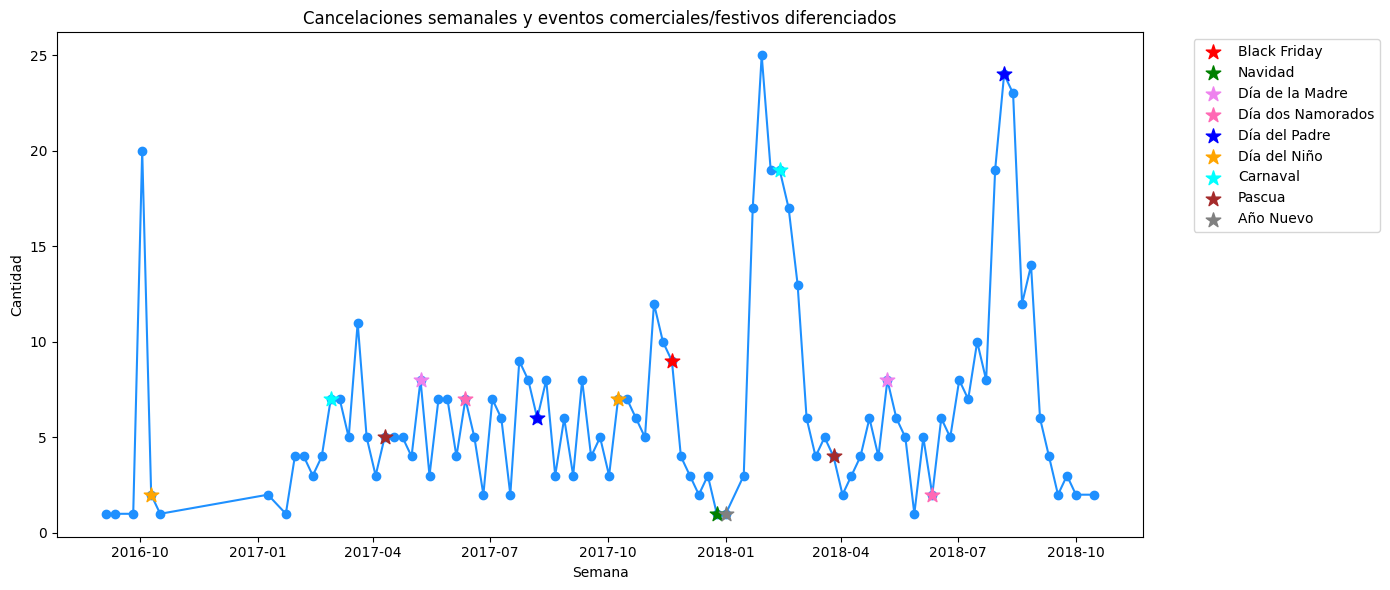

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(reclamos_semanales['ds'], reclamos_semanales['y'], marker='o', label='Cancelaciones', color='dodgerblue')

# Para leyenda única
handles = []
labels = []

for evento, color in colores_eventos.items():
    fechas_semana = eventos_df[eventos_df['evento'] == evento]['semana']
    y_event = reclamos_semanales[reclamos_semanales['ds'].isin(fechas_semana)]['y']
    ds_event = reclamos_semanales[reclamos_semanales['ds'].isin(fechas_semana)]['ds']
    h = plt.scatter(ds_event, y_event, color=color, s=120, marker='*', label=evento, zorder=5)
    handles.append(h)
    labels.append(evento)

plt.title('Cancelaciones semanales y eventos comerciales/festivos diferenciados')
plt.xlabel('Semana')
plt.ylabel('Cantidad')
plt.legend(handles, labels, bbox_to_anchor=(1.04, 1), loc='upper left')
plt.tight_layout()
plt.show()

En el gráfico se observa la evolución semanal de las cancelaciones (proxy de devoluciones/reclamos) en el e-commerce, junto con la ubicación temporal de los principales eventos comerciales y festivos de Brasil entre 2016 y 2018, destacados con estrellas de diferentes colores según cada evento.

Se puede notar que **varios de los picos más altos de cancelaciones coinciden con semanas de eventos clave como Black Friday, Carnaval, Día del Niño, Navidad, Año nuevo.** Esto es consistente con la lógica del e-commerce: en semanas de grandes campañas y festividades, aumenta el volumen de ventas, lo que típicamente resulta en más cancelaciones o reclamos.

Sin embargo, no todos los picos coinciden exactamente con una semana de evento, lo que puede explicarse por:

- El posible desfasaje temporal entre el evento y la materialización del reclamo (por ejemplo, las devoluciones pueden ocurrir una o dos semanas después del evento comercial).

- Problemas operativos, promociones específicas o hechos puntuales no calendarizados que impactan la operatoria.

**Conclusión:**
La presencia de estos picos alrededor de los eventos respalda la incorporación de variables exógenas (eventos/festivos) para mejorar la capacidad predictiva de los modelos, aunque también evidencia que otros factores internos y externos pueden incidir en las devoluciones semanales.

# **ENTRENAMIENTO MODELO TRANSFORMER CON VARIABLE EXÓGENA**

In [ ]:
# Matriz de features: [cancelaciones, evento_comercial]
serie_y = reclamos_semanales['y'].values.astype(np.float32)
serie_evento = reclamos_semanales['evento_comercial'].values.astype(np.float32)
features = np.column_stack([serie_y, serie_evento])

# Sliding window multivariada
tam_ventana = 8
horizonte = 1
X, y = [], []
for i in range(len(features) - tam_ventana - horizonte + 1):
    X.append(features[i : i + tam_ventana])
    y.append(serie_y[i + tam_ventana : i + tam_ventana + horizonte])
X = np.array(X)
y = np.array(y)

# Split en entrenamiento y test
split = int(len(X) * 0.9)
X_entrenamiento, X_test = X[:split], X[split:]
y_entrenamiento, y_test = y[:split], y[split:]

# Tensores PyTorch
X_entrenamiento_t = torch.tensor(X_entrenamiento)
y_entrenamiento_t = torch.tensor(y_entrenamiento)
X_test_t = torch.tensor(X_test)
y_test_t = torch.tensor(y_test)

dataset_entrenamiento = TensorDataset(X_entrenamiento_t, y_entrenamiento_t)
dataloader_entrenamiento = DataLoader(dataset_entrenamiento, batch_size=16, shuffle=True)

In [ ]:
# Modelo Transformer multivariado
class SimpleTransformer(nn.Module):
    def __init__(self, input_size=2, d_model=32, nhead=4, num_layers=1, out_size=1):
        super().__init__()
        self.linear_in = nn.Linear(input_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.linear_out = nn.Linear(d_model, out_size)
    def forward(self, x):
        x = self.linear_in(x)
        x = self.transformer(x)
        x = x[:, -1, :]
        return self.linear_out(x)

model = SimpleTransformer()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Entrenamiento
epochs = 100
model.train()
for epoch in range(epochs):
    losses = []
    for xb, yb in dataloader_entrenamiento:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss promedio: {np.mean(losses):.4f}")

Epoch 1/100 - Loss promedio: 6.4016
Epoch 10/100 - Loss promedio: 5.8139
Epoch 20/100 - Loss promedio: 5.8872
Epoch 30/100 - Loss promedio: 4.1589
Epoch 40/100 - Loss promedio: 4.3885
Epoch 50/100 - Loss promedio: 5.2373
Epoch 60/100 - Loss promedio: 4.9596
Epoch 70/100 - Loss promedio: 4.5955
Epoch 80/100 - Loss promedio: 4.6823
Epoch 90/100 - Loss promedio: 4.1730
Epoch 100/100 - Loss promedio: 5.3219


In [ ]:
# Evaluación
from sklearn.metrics import mean_absolute_error, mean_squared_error
model.eval()
with torch.no_grad():
    predicciones = model(X_test_t).squeeze().numpy()
mae_trans = mean_absolute_error(y_test, predicciones)
rmse_trans = np.sqrt(mean_squared_error(y_test, predicciones))
print(f"Transformer (con evento) - MAE: {mae_trans:.2f} | RMSE: {rmse_trans:.2f}")

Transformer (con evento) - MAE: 3.15 | RMSE: 5.20


# **ENTRENAMIENTO MODELO PROPHET CON VARIABLE EXÓGENA**

In [ ]:
from prophet import Prophet

# Armamos el dataframe para Prophet
prophet_df = reclamos_semanales[['ds', 'y', 'evento_comercial']].copy()
modelo_prophet = Prophet()
modelo_prophet.add_regressor('evento_comercial')
modelo_prophet.fit(prophet_df)

# Futuro: mismo horizonte que test
future = modelo_prophet.make_future_dataframe(periods=len(y_test), freq='W')
# Incorporamos la variable exógena en el futuro
future = future.merge(reclamos_semanales[['ds', 'evento_comercial']], on='ds', how='left')
future['evento_comercial'] = future['evento_comercial'].fillna(0)

forecast = modelo_prophet.predict(future)
y_pred_prophet = forecast['yhat'].values[-len(y_test):]

mae_prophet = mean_absolute_error(y_test, y_pred_prophet)
rmse_prophet = np.sqrt(mean_squared_error(y_test, y_pred_prophet))
print(f"Prophet (con evento) - MAE: {mae_prophet:.2f} | RMSE: {rmse_prophet:.2f}")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpux1hrkwc/jjqthqrk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpux1hrkwc/c6jd2vbs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82370', 'data', 'file=/tmp/tmpux1hrkwc/jjqthqrk.json', 'init=/tmp/tmpux1hrkwc/c6jd2vbs.json', 'output', 'file=/tmp/tmpux1hrkwc/prophet_modelgzo8q1pj/prophet_model-20250715050231.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:02:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:02:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet (con evento) - MAE: 5.55 | RMSE: 7.00


## **COMPARACIÓN DE MODELOS: PROPHET vs TRANSFORMER (Con variable exógena)**

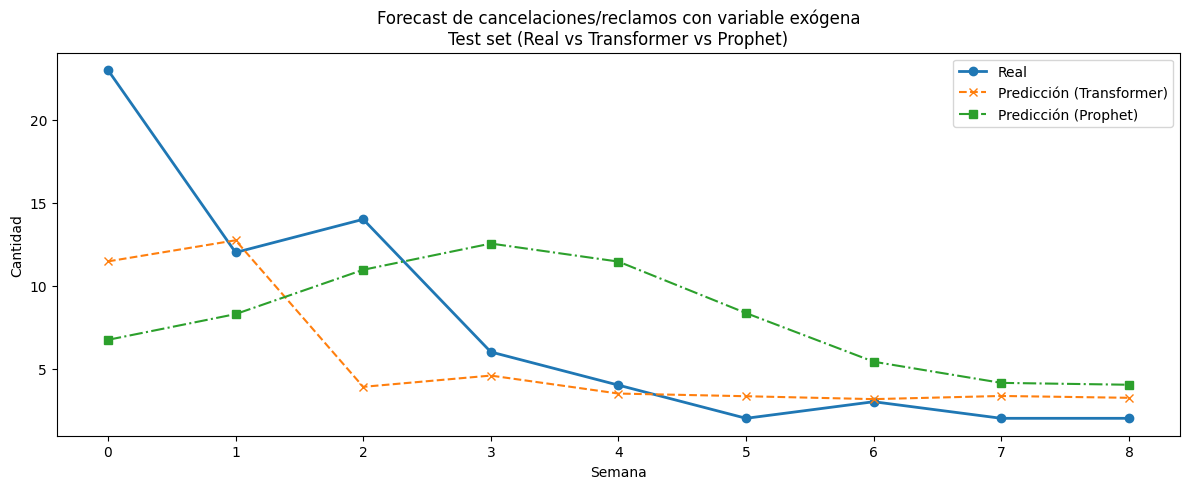

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(range(len(y_test)), y_test, label='Real', linewidth=2, marker='o')
plt.plot(range(len(predicciones)), predicciones, label='Predicción (Transformer)', linestyle='--', marker='x')
plt.plot(range(len(y_pred_prophet)), y_pred_prophet, label='Predicción (Prophet)', linestyle='-.', marker='s')
plt.title('Forecast de cancelaciones/reclamos con variable exógena\nTest set (Real vs Transformer vs Prophet)')
plt.xlabel('Semana')
plt.ylabel('Cantidad')
plt.legend()
plt.tight_layout()
plt.show()

# **CONCLUSIÓN FINAL**

En este trabajo se abordó el desafío de predecir cancelaciones/reclamos semanales en e-commerce usando dos enfoques complementarios: Prophet (modelo tradicional de series temporales) y un Transformer reducido (deep learning), con y sin la incorporación de una variable exógena que indica eventos comerciales/festivos clave en Brasil.

**Resultados obtenidos:**
Ningún modelo logró anticipar perfectamente los picos abruptos ni explicar toda la variabilidad semanal. Sin embargo, ambos lograron captar la tendencia general y se observó una mejora parcial en la performance al sumar la variable de eventos, sobre todo en la capacidad de anticipar semanas potencialmente críticas.

**Justificación de los resultados obtenidos:**
La predicción de eventos de tipo cancelacion es un reto incluso para modelos avanzados, especialmente sin variables adicionales que reflejen toda la complejidad del negocio real.

La variable exógena de eventos/festivos aporta contexto, pero no explica por sí sola la totalidad de los cambios en la serie. Esto es esperable, ya que en la práctica factores como promociones internas, problemas logísticos, lanzamientos o incidentes operativos también impactan y no están reflejados en los datos disponibles.

El trabajo refleja fielmente una situación real del forecasting en e-commerce: los modelos pueden anticipar tendencias y mejorar la planificación operativa, pero siempre existe incertidumbre asociada a eventos no modelados explícitamente.

Los resultados obtenidos sirven como baseline sólido y como diagnóstico para plantear próximas mejoras, como la incorporación de más variables externas, un mayor horizonte de datos o el ajuste de la arquitectura/modelos.

Sin embargo, en el trabajo pudé lograr comparar enfoques clásicos y de deep learning en series temporales, aplicar ingeniería de features y demostrar el impacto de la información exógena en el forecasting semanal de cancelaciones. Las conclusiones obtenidas son valiosas tanto para la operación como para futuros desarrollos en analítica y modelos predictivos.